# Assignment 5

1. Understand and implement the different initialization methods given below - 
Zeros, Random, Xavier, He

2. Understand and implement the different activation functions given below - 
(sigmoid, tanh, relu, leaky-relu)

3. Perform experiments using various combinations of initialization methods and
activation functions and analyze the error rate, accuracy and convergence time. 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import sklearn
import sklearn.datasets
import os

### Using following Activation functions

In [2]:
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

In [3]:
def relu(x):
    s = np.maximum(0,x)
    return s

### Forward , Backward propagation and parameter update 
Simple 3 perceptron neural network.

In [4]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation 
    Returns: Loss function (vanilla logistic loss)
    """   
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    z1 = np.dot(W1, X) + b1
    a1 = relu(z1)
    z2 = np.dot(W2, a1) + b2
    a2 = relu(z2)
    z3 = np.dot(W3, a2) + b3
    a3 = sigmoid(z3)
    
    cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)
    
    return a3, cache

In [5]:
def backward_propagation(X, Y, cache):
    """
    Implement the backward propagation.
    Returns: Gradients wrt each parameter, activation and pre-activation variables.
    """
    m = X.shape[1]
    (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache
    
    dz3 = 1./m * (a3 - Y)
    dW3 = np.dot(dz3, a2.T)
    db3 = np.sum(dz3, axis=1, keepdims = True)
    
    da2 = np.dot(W3.T, dz3)
    dz2 = np.multiply(da2, np.int64(a2 > 0))
    dW2 = np.dot(dz2, a1.T)
    db2 = np.sum(dz2, axis=1, keepdims = True)
    
    da1 = np.dot(W2.T, dz2)
    dz1 = np.multiply(da1, np.int64(a1 > 0))
    dW1 = np.dot(dz1, X.T)
    db1 = np.sum(dz1, axis=1, keepdims = True)
    
    gradients = {"dz3": dz3, "dW3": dW3, "db3": db3,
                 "da2": da2, "dz2": dz2, "dW2": dW2, "db2": db2,
                 "da1": da1, "dz1": dz1, "dW1": dW1, "db1": db1}
    
    return gradients

In [6]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent. Return parameter.
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for k in range(L):
        parameters["W" + str(k+1)] = parameters["W" + str(k+1)] - learning_rate * grads["dW" + str(k+1)]
        parameters["b" + str(k+1)] = parameters["b" + str(k+1)] - learning_rate * grads["db" + str(k+1)]
        
    return parameters

In [7]:
def lossValue(a3, Y):  
    m = Y.shape[1]
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    loss = 1./m * np.nansum(logprobs)
    
    return loss

In [8]:
def predict(X, y, parameters):
    """
    Predict the result (class of sample)
    """
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = int)
    
    # Forward propagation
    a3, caches = forward_propagation(X, parameters)
    
    # convert probas to 0/1 predictions
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    # print results
    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()
    
def predict_dec(parameters, X):
    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3>0.5)
    return predictions

In [9]:
def model(X, Y, learning_rate = 0.01, num_iterations = 15000, print_cost = True, initialization = "he"):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (containing 0 for red dots; 1 for blue dots), of shape (1, number of examples)
    learning_rate -- learning rate for gradient descent 
    num_iterations -- number of iterations to run gradient descent
    print_cost -- if True, print the cost every 1000 iterations
    initialization -- flag to choose which initialization to use ("zeros","random" or "he")
    
    Returns:
    parameters -- parameters learnt by the model
    """
        
    grads = {}
    costs = [] # to keep track of the loss
    m = X.shape[1] # number of examples
    layers_dims = [X.shape[0], 10, 5, 1]
    
    # Initialize parameters dictionary.
    if initialization == "zeros":
        parameters = initialize_parameters_zeros(layers_dims)
    elif initialization == "random":
        parameters = initialize_parameters_random(layers_dims)
    elif initialization == "he":
        parameters = initialize_parameters_he(layers_dims)
    elif initialization == "xavier":
        parameters = initialize_parameters_xavier(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        a3, cache = forward_propagation(X, parameters)
        
        # Loss
        cost = lossValue(a3, Y)

        # Backward propagation.
        grads = backward_propagation(X, Y, cache)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
            costs.append(cost)
            
    # plot the loss
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters


# Initialization Functions

In [10]:
## Zero initialization
def initialize_parameters_zeros(layers_dims):
    parameters = {}
    L = len(layers_dims)            # number of layers in the network
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.zeros((layers_dims[l],layers_dims[l-1]))
        parameters['b' + str(l)] = np.zeros((layers_dims[l],1))
    return parameters

In [11]:
# Random intialization

def initialize_parameters_random(layers_dims):
   
    np.random.seed(3)               # This seed makes sure your "random" numbers will be the as ours
    parameters = {}
    L = len(layers_dims)            # integer representing the number of layers
    
    for l in range(1, L):
        ### START CODE HERE ### (≈ 2 lines of code)
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * 10
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        ### END CODE HERE ###

    return parameters


In [12]:
# Xavier Initialization

def initialize_parameters_xavier(layers_dims):   
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1 
    for l in range(1, L + 1):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * np.sqrt(2 / (layers_dims[l - 1] + layers_dims[l]))
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))     
    return parameters


In [13]:
# HE Initialization

def initialize_parameters_he(layers_dims):   
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1 
    for l in range(1, L + 1):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * np.sqrt(2 / layers_dims[l - 1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))     
    return parameters


### 1. MAKEMOONS DATASET OR MAKE CIRCLES

In [14]:
def load_dataset_makemoons():
    np.random.seed(1)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=300, noise=.05) #make_circles
    np.random.seed(2)
    test_X, test_Y = sklearn.datasets.make_moons(n_samples=100, noise=.05)
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    test_X = test_X.T
    test_Y = test_Y.reshape((1, test_Y.shape[0]))
    return train_X, train_Y, test_X, test_Y

/tmp/ipykernel_7542/534213536.py:2: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('matplotlib inline')


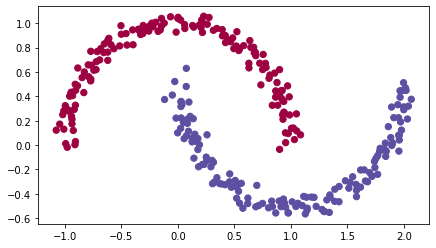

In [15]:
# LOAD DATASET
get_ipython().magic('matplotlib inline')
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# load image dataset: blue/red dots in circles
train_X, train_Y, test_X, test_Y = load_dataset_makemoons()

#### 1. ZERO INITIALIZATION

W1 = [[0. 0. 0.]
 [0. 0. 0.]]
b1 = [[0.]
 [0.]]
W2 = [[0. 0.]]
b2 = [[0.]]
Cost after iteration 0: 0.6931471805599453
Cost after iteration 1000: 0.6931471805599453
Cost after iteration 2000: 0.6931471805599453
Cost after iteration 3000: 0.6931471805599453
Cost after iteration 4000: 0.6931471805599453
Cost after iteration 5000: 0.6931471805599453
Cost after iteration 6000: 0.6931471805599453
Cost after iteration 7000: 0.6931471805599453
Cost after iteration 8000: 0.6931471805599453
Cost after iteration 9000: 0.6931471805599453
Cost after iteration 10000: 0.6931471805599455
Cost after iteration 11000: 0.6931471805599453
Cost after iteration 12000: 0.6931471805599453
Cost after iteration 13000: 0.6931471805599453
Cost after iteration 14000: 0.6931471805599453


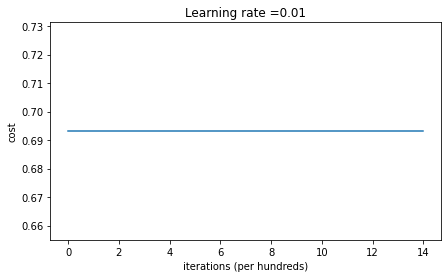

On the train set:
Accuracy: 0.5
On the test set:
Accuracy: 0.5


In [16]:
parameters = initialize_parameters_zeros([3,2,1]) 
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
parameters = model(train_X, train_Y, initialization = "zeros")
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

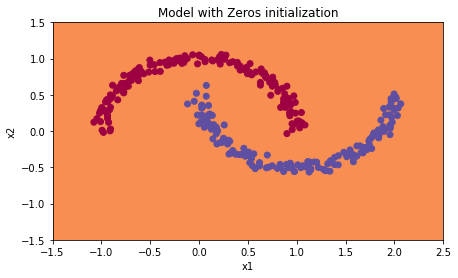

In [17]:
# print ("predictions_train = " + str(predictions_train))
# print ("predictions_test = " + str(predictions_test))
plt.title("Model with Zeros initialization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

#### 2. RANDOM INITIALIZATION

W1 = [[ 17.88628473   4.36509851]
 [  0.96497468 -18.63492703]
 [ -2.77388203  -3.54758979]]
b1 = [[0.]
 [0.]
 [0.]]
W2 = [[-0.82741481 -6.27000677 -0.43818169]]
b2 = [[0.]]
Cost after iteration 0: inf


/tmp/ipykernel_7542/1338456155.py:3: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
/tmp/ipykernel_7542/1338456155.py:3: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
/tmp/ipykernel_7542/2464296198.py:2: RuntimeWarning: overflow encountered in exp
  s = 1/(1+np.exp(-x))


Cost after iteration 1000: 0.30063709472338834
Cost after iteration 2000: 1.1662046973218942
Cost after iteration 3000: 0.2938988834949915
Cost after iteration 4000: 0.3650261965016988
Cost after iteration 5000: 0.26045408782314156
Cost after iteration 6000: 0.2448065697073525
Cost after iteration 7000: 0.24497964389688548
Cost after iteration 8000: 0.24546547301486168
Cost after iteration 9000: 0.24743241763247906
Cost after iteration 10000: 0.2453363575786737
Cost after iteration 11000: 0.24356649482199696
Cost after iteration 12000: 0.24207550124633487
Cost after iteration 13000: 0.24082572460924775
Cost after iteration 14000: 0.23980127388853453


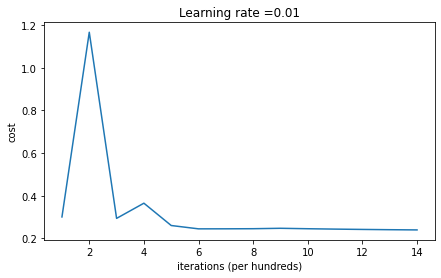

On the train set:
Accuracy: 0.8866666666666667
On the test set:
Accuracy: 0.87


In [18]:
parameters = initialize_parameters_random([2,3,1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
parameters = model(train_X, train_Y, initialization = "random")
print("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

/tmp/ipykernel_7542/2464296198.py:2: RuntimeWarning: overflow encountered in exp
  s = 1/(1+np.exp(-x))


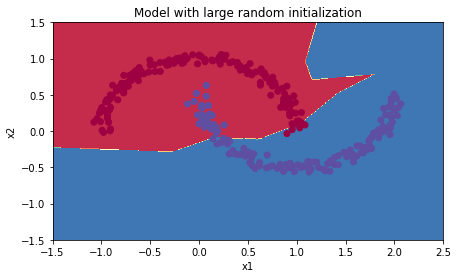

In [19]:
# print(predictions_train)
# print(predictions_test)
plt.title("Model with large random initialization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1.5, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

#### 3. HE INITIALIZATION

W1 = [[ 1.78862847  0.43650985]
 [ 0.09649747 -1.8634927 ]
 [-0.2773882  -0.35475898]]
b1 = [[0.]
 [0.]
 [0.]]
W2 = [[-0.06755814 -0.51194391 -0.03577739]]
b2 = [[0.]]
Cost after iteration 0: 0.7342482321384683
Cost after iteration 1000: 0.29566497970575834
Cost after iteration 2000: 0.25184038318406815
Cost after iteration 3000: 0.22284974489831486
Cost after iteration 4000: 0.197785000749911
Cost after iteration 5000: 0.17049197570926788
Cost after iteration 6000: 0.13351846788644978
Cost after iteration 7000: 0.09373065428140329
Cost after iteration 8000: 0.06003854894423608
Cost after iteration 9000: 0.03672540881648471
Cost after iteration 10000: 0.023649094476709844
Cost after iteration 11000: 0.016344535872923487
Cost after iteration 12000: 0.01199999604658859
Cost after iteration 13000: 0.009296262994410533
Cost after iteration 14000: 0.007550730111146192


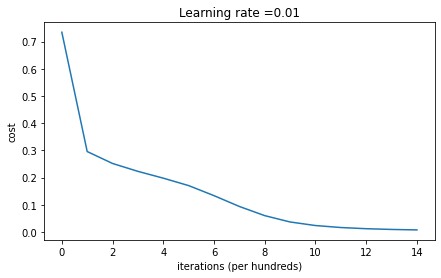

On the train set:
Accuracy: 1.0
On the test set:
Accuracy: 1.0


In [20]:
parameters = initialize_parameters_he([2, 3, 1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
parameters = model(train_X, train_Y, initialization = "he")
print("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

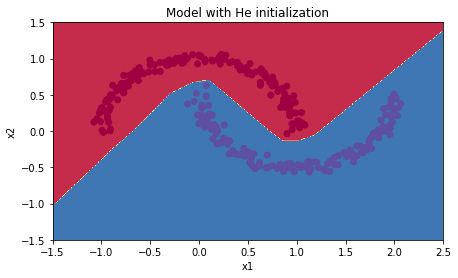

In [21]:
plt.title("Model with He initialization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1.5, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

#### 3. XAVIER INITIALIZATION

W1 = [[ 1.78862847  0.43650985]
 [ 0.09649747 -1.8634927 ]
 [-0.2773882  -0.35475898]]
b1 = [[0.]
 [0.]
 [0.]]
W2 = [[-0.06755814 -0.51194391 -0.03577739]]
b2 = [[0.]]
Cost after iteration 0: 0.6694101222445528
Cost after iteration 1000: 0.30526126985263696
Cost after iteration 2000: 0.22138739654881626
Cost after iteration 3000: 0.18193024980755615
Cost after iteration 4000: 0.13620749020417489
Cost after iteration 5000: 0.08893639638630692
Cost after iteration 6000: 0.05489488597077587
Cost after iteration 7000: 0.03553033959372304
Cost after iteration 8000: 0.024874180478534222
Cost after iteration 9000: 0.018546759352835625
Cost after iteration 10000: 0.014518566147216763
Cost after iteration 11000: 0.011781754225485528
Cost after iteration 12000: 0.009821203449934573
Cost after iteration 13000: 0.008373494980250622
Cost after iteration 14000: 0.007261394168140397


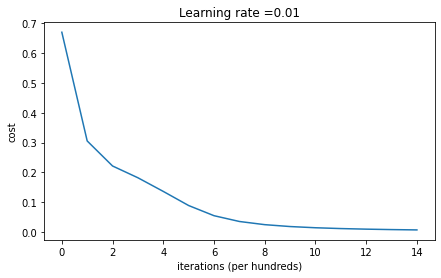

On the train set:
Accuracy: 1.0
On the test set:
Accuracy: 1.0


In [22]:
parameters = initialize_parameters_he([2,3,1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
parameters = model(train_X, train_Y, initialization = "xavier")
print("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

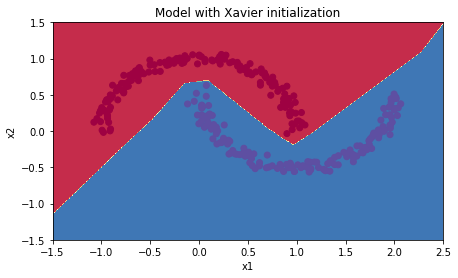

In [23]:
plt.title("Model with Xavier initialization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1.5, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)